## Data Processing

In [21]:
SEQ_LEN_IN = 128
SEQ_LEN_OUT = 10
NUM_FEATURES_IN = 121
NUM_FEATURES_OUT = 121
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
BATCH_SIZE = 64
EPOCHS = 1000
PATIENCE = 15

In [22]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load
import keras
from sklearn.model_selection import train_test_split

In [23]:
def create_sequences_for_seq2seq(data, seq_len_in, seq_len_out, train_size=0.7, val_size=0.15):
    X_enc, y = [], []

    for i in range(len(data) - (seq_len_in + seq_len_out) + 1):
        X_enc.append(data[i : i + seq_len_in])
        y.append(data[i + seq_len_in : i + seq_len_in + seq_len_out])

    X_enc = np.array(X_enc)
    y = np.array(y)

    X_dec = y

    total_samples = len(X_enc)
    train_end = int(total_samples * train_size)
    val_end = int(total_samples * (train_size + val_size))

    X_train_enc, y_train = X_enc[:train_end], y[:train_end]
    X_val_enc, y_val = X_enc[train_end:val_end], y[train_end:val_end]
    X_test_enc, y_test = X_enc[val_end:], y[val_end:]

    X_train_dec = X_dec[:train_end]
    X_val_dec = X_dec[train_end:val_end]
    X_test_dec = X_dec[val_end:]

    return (
        X_train_enc, X_val_enc, X_test_enc,
        X_train_dec, X_val_dec, X_test_dec,
        y_train, y_val, y_test
    )

In [24]:
BLOCK_SIZE = 128

N_BINS_SOH = 5

print("--- Fase 1: Caricamento e preparazione dei dati ---")
files = glob.glob("cell*.csv")
dataframes = []
for path in files:
    cell = os.path.basename(path).split('.')[0]
    df = pd.read_csv(path)
    df.drop(columns=[col for col in df.columns if col.startswith('f_')], inplace=True)
    df['Cell'] = cell
    dataframes.append(df)
df_all = pd.concat(dataframes, ignore_index=True)
feature_cols = [col for col in df_all.columns if col != 'Cell']




print(f"\n--- Fase 2: Creazione di blocchi (dimensione: {BLOCK_SIZE} cicli) ---")

X_enc_blocks, X_dec_blocks, y_blocks = [], [], []
cell_id_per_block = []
soh_avg_per_block = []

scalers_per_cell = {}

def create_all_sequences(data, seq_len_in, seq_len_out):
    X_enc, y = [], []
    for i in range(len(data) - (seq_len_in + seq_len_out) + 1):
        X_enc.append(data[i : i + seq_len_in])
        y.append(data[i + seq_len_in : i + seq_len_in + seq_len_out])
    
    if not X_enc:
        return None, None, None
        
    X_enc, y = np.array(X_enc), np.array(y)
    X_dec = y
    return X_enc, X_dec, y

for cell_id, group in df_all.groupby('Cell'):
    print(f"Processando cella: {cell_id}")
    scaler = StandardScaler()
    data_to_scale = group[feature_cols].values
    
    if len(data_to_scale) < SEQ_LEN_IN + SEQ_LEN_OUT:
        print(f"  -> Dati insufficienti per {cell_id}. Saltato.")
        continue
        
    data_cell_scaled = scaler.fit_transform(data_to_scale)
    scalers_per_cell[cell_id] = scaler

    X_enc_cell, X_dec_cell, y_cell = create_all_sequences(data_cell_scaled, SEQ_LEN_IN, SEQ_LEN_OUT)
    if X_enc_cell is None:
        continue

    num_sequences_in_cell = len(X_enc_cell)
    for i in range(0, num_sequences_in_cell, BLOCK_SIZE):
        start_idx = i
        end_idx = i + BLOCK_SIZE
        
        if end_idx > num_sequences_in_cell:
            continue

        X_enc_blocks.append(X_enc_cell[start_idx:end_idx])
        X_dec_blocks.append(X_dec_cell[start_idx:end_idx])
        y_blocks.append(y_cell[start_idx:end_idx])
        
        cell_id_per_block.append(cell_id)
        soh_avg_per_block.append(np.mean(y_cell[start_idx:end_idx, :, -1]))

dump(scalers_per_cell, 'scalers_per_cell.joblib')
print(f"Creati {len(X_enc_blocks)} blocchi totali.")

print("\n--- Fase 3: Esecuzione dello split stratificato sui blocchi ---")

block_indices = np.arange(len(X_enc_blocks))

soh_bins = pd.cut(soh_avg_per_block, bins=N_BINS_SOH, labels=False)

train_val_indices, test_indices = train_test_split(
    block_indices,
    test_size=(1 - TRAIN_SPLIT - VAL_SPLIT), 
    stratify=soh_bins,
    random_state=42
)

soh_bins_train_val = soh_bins[train_val_indices]
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=VAL_SPLIT / (TRAIN_SPLIT + VAL_SPLIT),
    stratify=soh_bins_train_val,
    random_state=42
)

print("\n--- Fase 4: Costruzione dei set di training, validazione e test ---")

def build_dataset_from_blocks(indices, x_enc_b, x_dec_b, y_b, cell_ids_b):
    if len(indices) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    X_enc = np.concatenate([x_enc_b[i] for i in indices], axis=0)
    X_dec = np.concatenate([x_dec_b[i] for i in indices], axis=0)
    y = np.concatenate([y_b[i] for i in indices], axis=0)
    
    cell_ids_list = []
    for i in indices:
        cell_ids_list.extend([cell_ids_b[i]] * len(y_b[i]))
    
    return X_enc, X_dec, y, np.array(cell_ids_list)

X_train_enc, X_train_dec, y_train, cell_ids_train = build_dataset_from_blocks(train_indices, X_enc_blocks, X_dec_blocks, y_blocks, cell_id_per_block)
X_val_enc, X_val_dec, y_val, cell_ids_val = build_dataset_from_blocks(val_indices, X_enc_blocks, X_dec_blocks, y_blocks, cell_id_per_block)
X_test_enc, X_test_dec, y_test, cell_ids_test = build_dataset_from_blocks(test_indices, X_enc_blocks, X_dec_blocks, y_blocks, cell_id_per_block)

print("\n--- Fase 5: Mescolamento delle sequenze all'interno dei set ---\n")

def shuffle_sets(*arrays):
    if not all(len(arr) > 0 for arr in arrays):
        return arrays
    idx = np.random.permutation(len(arrays[0]))
    return [arr[idx] for arr in arrays]

X_train_enc, X_train_dec, y_train, cell_ids_train = shuffle_sets(X_train_enc, X_train_dec, y_train, cell_ids_train)
X_val_enc, X_val_dec, y_val, cell_ids_val = shuffle_sets(X_val_enc, X_val_dec, y_val, cell_ids_val)
#X_test_enc, X_test_dec, y_test, cell_ids_test = shuffle_sets(X_test_enc, X_test_dec, y_test, cell_ids_test)

print(f"Forma finale X_train_enc: {X_train_enc.shape}")
print(f"Forma finale y_train: {y_train.shape}")
print(f"Forma finale X_val_enc: {X_val_enc.shape}")
print(f"Forma finale y_val: {y_val.shape}")
print(f"Forma X_test_enc (prima dell'ordinamento): {X_test_enc.shape}")
print(f"Forma y_test (prima dell'ordinamento): {y_test.shape}")
print(f"Forma cell_ids_test (prima dell'ordinamento): {cell_ids_test.shape}")


print("Test set ordinato con successo.")
print("\nVerifica dell'ordinamento:")
print(f"Primi 10 ID cella nel test set ordinato: {cell_ids_test[:10]}")
print(f"Ultimi 10 ID cella nel test set ordinato: {cell_ids_test[-10:]}")

--- Fase 1: Caricamento e preparazione dei dati ---

--- Fase 2: Creazione di blocchi (dimensione: 128 cicli) ---
Processando cella: cella_1_sorted
Processando cella: cella_2_sorted
Processando cella: cella_5_sorted
Creati 75 blocchi totali.

--- Fase 3: Esecuzione dello split stratificato sui blocchi ---

--- Fase 4: Costruzione dei set di training, validazione e test ---

--- Fase 5: Mescolamento delle sequenze all'interno dei set ---

Forma finale X_train_enc: (6528, 128, 121)
Forma finale y_train: (6528, 10, 121)
Forma finale X_val_enc: (1536, 128, 121)
Forma finale y_val: (1536, 10, 121)
Forma X_test_enc (prima dell'ordinamento): (1536, 128, 121)
Forma y_test (prima dell'ordinamento): (1536, 10, 121)
Forma cell_ids_test (prima dell'ordinamento): (1536,)
Test set ordinato con successo.

Verifica dell'ordinamento:
Primi 10 ID cella nel test set ordinato: ['cella_1_sorted' 'cella_1_sorted' 'cella_1_sorted' 'cella_1_sorted'
 'cella_1_sorted' 'cella_1_sorted' 'cella_1_sorted' 'cella_1_

In [25]:
def complex_mse_loss(y_true, y_pred):
    """
    Calcola l'errore quadratico medio sul piano complesso.
    Questo forza il modello a imparare la relazione tra parte reale e immaginaria.
    """

    r_idx = tf.constant(list(range(0, 118, 2)))
    i_idx = tf.constant(list(range(1, 118, 2)))

    # tf.gather permette di selezionare colonne specifiche da un tensore
    re_true = tf.gather(y_true, r_idx, axis=-1)
    im_true = tf.gather(y_true, i_idx, axis=-1)

    re_pred = tf.gather(y_pred, r_idx, axis=-1)
    im_pred = tf.gather(y_pred, i_idx, axis=-1)

    z_true = tf.complex(re_true, im_true)
    z_pred = tf.complex(re_pred, im_pred)

    error = tf.abs(z_true - z_pred)
    complex_mse = tf.reduce_mean(tf.square(error))

    return complex_mse

In [26]:
def combined_loss(y_true, y_pred):
    # Pesi per le diverse componenti della loss
    alpha = 10.0  # Peso per la loss complessa
    beta = 1.0   # Peso per la loss sulla temperatura
    gamma = 1.0  # Peso per la loss su SOH

    complex_loss = complex_mse_loss(y_true, y_pred)

    #temp_true = y_true[:, :, -2]
    soh_true = y_true[:, :, -1]
    #temp_pred = y_pred[:, :, -2]
    soh_pred = y_pred[:, :, -1]

    #temp_mse = tf.reduce_mean(tf.square(temp_true - temp_pred))
    soh_mse = tf.reduce_mean(tf.square(soh_true - soh_pred))

    total_loss = (alpha * complex_loss) + (gamma * soh_mse)
    return total_loss

In [27]:
@keras.saving.register_keras_serializable()
class EncoderDecoderTransformer(tf.keras.Model):
    def __init__(self, 
                 seq_len_in, seq_len_out, 
                 num_features_in, num_features_out,
                 d_model=64, num_heads=4, ff_dim=128,
                 num_encoder_layers=4, num_decoder_layers=4,
                 dropout=0.1, **kwargs):
        super().__init__(**kwargs)

        # --- Parametri principali ---
        self.seq_len_in = seq_len_in
        self.seq_len_out = seq_len_out
        self.num_features_in = num_features_in
        self.num_features_out = num_features_out
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dropout = dropout

        # --- ENCODER ---
        self.encoder_input_proj = layers.Dense(d_model)
        # positional embedding fino a seq_len_in (128), ma funziona anche se <128
        self.encoder_pos_embedding = layers.Embedding(input_dim=seq_len_in, output_dim=d_model)

        self.encoder_layers = [
            (
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout),
                layers.Dropout(dropout),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(ff_dim, activation='relu'),
                layers.Dense(d_model),
                layers.Dropout(dropout)
            ) for _ in range(num_encoder_layers)
        ]

        # --- DECODER ---
        self.decoder_input_proj = layers.Dense(d_model)
        # positional embedding fino a seq_len_out (10)
        self.decoder_pos_embedding = layers.Embedding(input_dim=seq_len_out, output_dim=d_model)

        self.decoder_layers = [
            (
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout),
                layers.Dropout(dropout),
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout),
                layers.Dropout(dropout),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(ff_dim, activation='relu'),
                layers.Dense(d_model),
                layers.Dropout(dropout)
            ) for _ in range(num_decoder_layers)
        ]

        self.output_proj = layers.Dense(num_features_out)

    # ---- MASCHERA CAUSALE DINAMICA ----
    @staticmethod
    def get_causal_attention_mask(x):
        """
        Crea una maschera causale (triangolare inferiore) adattata alla lunghezza runtime.
        """
        seq_len = tf.shape(x)[1]
        i = tf.range(seq_len)[:, None]
        j = tf.range(seq_len)
        mask = tf.cast(i >= j, dtype=tf.float32)
        return mask[None, :, :]  # (1, seq_len, seq_len)

    # ---- FORWARD PASS ----
    def call(self, inputs, training=False):
        encoder_input, decoder_input = inputs

        # === ENCODER ===
        encoder_positions = tf.range(start=0, limit=tf.shape(encoder_input)[1], delta=1)
        x = self.encoder_input_proj(encoder_input)
        x += self.encoder_pos_embedding(encoder_positions)

        for norm1, mha, drop1, norm2, ff1, ff2, drop2 in self.encoder_layers:
            attn_output = mha(query=norm1(x), value=norm1(x), key=norm1(x), training=training)
            x = x + drop1(attn_output, training=training)
            ffn_output = ff2(ff1(norm2(x)))
            x = x + drop2(ffn_output, training=training)
        encoder_output = x

        # === DECODER ===
        decoder_positions = tf.range(start=0, limit=tf.shape(decoder_input)[1], delta=1)
        y = self.decoder_input_proj(decoder_input)
        y += self.decoder_pos_embedding(decoder_positions)

        causal_mask = self.get_causal_attention_mask(y)

        for norm1, self_mha, drop1, norm2, cross_mha, drop2, norm3, ff1, ff2, drop3 in self.decoder_layers:
            self_attn_output = self_mha(
                query=norm1(y), value=norm1(y), key=norm1(y),
                attention_mask=causal_mask, training=training
            )
            y = y + drop1(self_attn_output, training=training)

            cross_attn_output = cross_mha(
                query=norm2(y), value=encoder_output, key=encoder_output, training=training
            )
            y = y + drop2(cross_attn_output, training=training)

            ffn_output = ff2(ff1(norm3(y)))
            y = y + drop3(ffn_output, training=training)

        return self.output_proj(y)

    # ---- SERIALIZZAZIONE ----
    def get_config(self):
        config = {
            "seq_len_in": self.seq_len_in,
            "seq_len_out": self.seq_len_out,
            "num_features_in": self.num_features_in,
            "num_features_out": self.num_features_out,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_encoder_layers": self.num_encoder_layers,
            "num_decoder_layers": self.num_decoder_layers,
            "dropout": self.dropout,
        }
        base_config = super().get_config()
        base_config.update(config)
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [28]:
def print_eis_predictions(model, X_test_enc, X_test_dec, y_true_norm, scalers, cell_ids_test, index=0):
    """
    Esegue la predizione per un singolo campione di test e plotta la curva di Nyquist
    REALE vs PREDETTA per ogni timestep futuro, usando lo scaler corretto per la cella.

    Args:
        model (tf.keras.Model): Il modello addestrato.
        X_test_enc (np.ndarray): Dati di input per l'encoder del set di test.
        X_test_dec (np.ndarray): Dati di input per il decoder del set di test.
        y_true_norm (np.ndarray): Dati di target reali (normalizzati) del set di test.
        scalers (dict): Dizionario di scaler per cella.
        cell_ids_test (np.ndarray): Array con gli ID della cella per ogni campione di test.
        index (int): L’indice del campione da visualizzare nel set di test.
    """
    if index >= len(X_test_enc):
        print(f"Errore: l'indice {index} è fuori dai limiti. Il test set ha {len(X_test_enc)} campioni.")
        return

    sample_X_enc = np.expand_dims(X_test_enc[index], axis=0)
    sample_X_dec = np.expand_dims(X_test_dec[index], axis=0)
    
    y_pred_norm = model.predict([sample_X_enc, sample_X_dec], verbose=0)
    
    cell_id = cell_ids_test[index]
    scaler = scalers[cell_id]

    SEQ_LEN_OUT = y_true_norm.shape[1]
    n_cols = 5
    n_rows = (SEQ_LEN_OUT + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()

    titolo = f'Previsione Multi-Step per il Campione di Test {index} (Cella: {cell_id})'
    fig.suptitle(titolo, fontsize=16, y=1.02)

    for t in range(SEQ_LEN_OUT):
        ax = axes[t]

        true_sample_norm = y_true_norm[index, t, :]
        pred_sample_norm = y_pred_norm[0, t, :]
        
        true_sample_denorm = scaler.inverse_transform(true_sample_norm.reshape(1, -1)).flatten()
        pred_sample_denorm = scaler.inverse_transform(pred_sample_norm.reshape(1, -1)).flatten()
        
        # Indici reali e immaginari
        r_idx = list(range(0, 118, 2))
        i_idx = list(range(1, 118, 2))

        # Parte immaginaria negativa (standard per Nyquist)
        df_true = pd.DataFrame({'real': true_sample_denorm[r_idx], 'imag': true_sample_denorm[i_idx]})
        df_pred = pd.DataFrame({'real': pred_sample_denorm[r_idx], 'imag': pred_sample_denorm[i_idx]})

        
        # Ultime due feature: temperatura e SOH
        soh_true = true_sample_denorm[-1]
        soh_pred = pred_sample_denorm[-1]
        
        soh_true = np.round(soh_true, 0)
        soh_pred = np.round(soh_pred, 0)

        ax.plot(df_true['real'], df_true['imag'], 'o-', label='Reale', color='blue', markersize=4)
        ax.plot(df_pred['real'], df_pred['imag'], 'x--', label='Predetto', color='red', markersize=4)

        ax.set_xlabel('Re(Z) [Ω]')
        ax.set_ylabel('−Im(Z) [Ω]')
        ax.legend()

        title_text = (f'Timestep Futuro: +{t+1}\n'
                      f'SOH Reale: {soh_true:.3f} (Pred: {soh_pred:.3f})')
        ax.set_title(title_text, fontsize=9)
        ax.grid(True)
        ax.axis("equal")

    # Disattiva assi inutilizzati
    for i in range(SEQ_LEN_OUT, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [29]:
def evaluate_model_on_full_testset(model, X_test_enc, X_test_dec, y_test_norm, scaler):
    y_pred_norm = model.predict([X_test_enc, X_test_dec])

    nsamples, ntimesteps, nfeatures = y_test_norm.shape

    y_test_denorm = scaler.inverse_transform(y_test_norm.reshape(-1, nfeatures)).reshape(nsamples, ntimesteps, nfeatures)
    y_pred_denorm = scaler.inverse_transform(y_pred_norm.reshape(-1, nfeatures)).reshape(nsamples, ntimesteps, nfeatures)

    #temp_true = y_test_denorm[:, :, -2].flatten()
    #temp_pred = y_pred_denorm[:, :, -2].flatten()
    soh_true = y_test_denorm[:, :, -1].flatten()
    soh_pred = y_pred_denorm[:, :, -1].flatten()
    
    #temp_true = np.round(temp_true, 0)
    #temp_pred = np.round(temp_pred, 0)
    
    soh_true = np.round(soh_true, 0)
    soh_pred = np.round(soh_pred, 0)

    ridx = list(range(0, nfeatures-2, 2))
    iidx = list(range(1, nfeatures-2, 2))
    re_true = y_test_denorm[:, :, ridx].flatten()
    re_pred = y_pred_denorm[:, :, ridx].flatten()
    im_true = y_test_denorm[:, :, iidx].flatten()
    im_pred = y_pred_denorm[:, :, iidx].flatten()

    metrics = {
        #"temperature": {"r2": r2_score(temp_true, temp_pred), "mse": mean_squared_error(temp_true, temp_pred), "mae": mean_absolute_error(temp_true, temp_pred)},
        "soh": {"r2": r2_score(soh_true, soh_pred), "mse": mean_squared_error(soh_true, soh_pred), "mae": mean_absolute_error(soh_true, soh_pred)},
        "impedance_real": {"r2": r2_score(re_true, re_pred), "mse": mean_squared_error(re_true, re_pred), "mae": mean_absolute_error(re_true, re_pred)},
        "impedance_imag": {"r2": r2_score(im_true, im_pred), "mse": mean_squared_error(im_true, im_pred), "mae": mean_absolute_error(im_true, im_pred)}
    }
    
    print("--- Metriche Aggregate sul Test Set (con Scaler Globale) ---")
    for key, vals in metrics.items():
        print(f"{key}: R2={vals['r2']:.4f}, MSE={vals['mse']:.4f}, MAE={vals['mae']:.4f}")

    return metrics

In [30]:
def evaluate_model_per_cell(model, X_test_enc, X_test_dec, y_test, scalers, cell_ids_test, cell_id_to_evaluate):
    """
    Valuta le performance del modello sui dati di test di una specifica cella,
    usando lo scaler addestrato solo su quella cella.

    Args:
        model (tf.keras.Model): Il modello addestrato.
        X_test_enc, X_test_dec, y_test: L'intero set di test.
        scalers (dict): Dizionario contenente gli scaler per ogni cella.
        cell_ids_test (np.ndarray): Array con gli ID delle celle per ogni campione di test.
        cell_id_to_evaluate (str): L'ID della cella da valutare (es. 'cell_1').
    """
    print(f"--- Inizio Valutazione Specifica per '{cell_id_to_evaluate}' ---")
    
    indices = np.where(cell_ids_test == cell_id_to_evaluate)[0]
    if len(indices) == 0:
        print(f"Nessun campione di test trovato per '{cell_id_to_evaluate}'.")
        return None

    X_enc_cell = X_test_enc[indices]
    X_dec_cell = X_test_dec[indices]
    y_true_norm = y_test[indices]

    try:
        scaler = scalers[cell_id_to_evaluate]
    except KeyError:
        print(f"Errore: Scaler per '{cell_id_to_evaluate}' non trovato.")
        return None

    print(f"Esecuzione previsioni su {len(X_enc_cell)} campioni per '{cell_id_to_evaluate}'...")
    y_pred_norm = model.predict([X_enc_cell, X_dec_cell], batch_size=BATCH_SIZE, verbose=0)
    
    n_samples, n_timesteps, n_features = y_true_norm.shape
    y_true_denorm = scaler.inverse_transform(y_true_norm.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
    y_pred_denorm = scaler.inverse_transform(y_pred_norm.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)

    #temp_true = y_true_denorm[:, :, -2].flatten()
    #temp_pred = y_pred_denorm[:, :, -2].flatten()
    soh_true = y_true_denorm[:, :, -1].flatten()
    soh_pred = y_pred_denorm[:, :, -1].flatten()
    
    #temp_true = np.round(temp_true, 0)
    #temp_pred = np.round(temp_pred, 0)
    
    soh_true = np.round(soh_true, 0)
    soh_pred = np.round(soh_pred, 0)
    
    ridx = list(range(0, n_features-2, 2))
    iidx = list(range(1, n_features-2, 2))
    re_true = y_true_denorm[:, :, ridx].flatten()
    re_pred = y_pred_denorm[:, :, ridx].flatten()
    im_true = y_true_denorm[:, :, iidx].flatten()
    im_pred = y_pred_denorm[:, :, iidx].flatten()

    metrics = {
        #"temperature": {"r2": r2_score(temp_true, temp_pred), "mse": mean_squared_error(temp_true, temp_pred), "mae": mean_absolute_error(temp_true, temp_pred)},
        "soh": {"r2": r2_score(soh_true, soh_pred), "mse": mean_squared_error(soh_true, soh_pred), "mae": mean_absolute_error(soh_true, soh_pred)},
        "impedance_real": {"r2": r2_score(re_true, re_pred), "mse": mean_squared_error(re_true, re_pred), "mae": mean_absolute_error(re_true, re_pred)},
        "impedance_imag": {"r2": r2_score(im_true, im_pred), "mse": mean_squared_error(im_true, im_pred), "mae": mean_absolute_error(im_true, im_pred)}
    }
    
    print(f"\n--- RISULTATI PER '{cell_id_to_evaluate}' ---")
    for key, vals in metrics.items():
        print(f"  {key:<15}: R2={vals['r2']:.4f}, MSE={vals['mse']:.4f}, MAE={vals['mae']:.4f}")
    
    return metrics

In [31]:
def create_lstm_seq2seq_model(seq_len_in, num_features_in, seq_len_out, num_features_out, 
                                latent_dim=64, num_encoder_layers=3, dropout=0.2):
    """
    Crea un modello LSTM Encoder-Decoder (Seq2Seq) usando l'API Funzionale di Keras.
    """
    # --- ENCODER ---
    encoder_inputs = layers.Input(shape=(None, num_features_in), name='encoder_input')
    
    encoder_lstm_outputs = encoder_inputs
    for i in range(num_encoder_layers - 1):
        encoder_lstm_outputs = layers.LSTM(latent_dim, return_sequences=True)(encoder_lstm_outputs)
        encoder_lstm_outputs = layers.Dropout(dropout)(encoder_lstm_outputs)

    _, state_h, state_c = layers.LSTM(latent_dim, return_state=True, name='encoder_lstm_last')(encoder_lstm_outputs)
    encoder_states = [state_h, state_c] # Questo è il "vettore di contesto".

    # --- DECODER ---
    decoder_inputs = layers.Input(shape=(None, num_features_out), name='decoder_input')
    
    decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, name='decoder_lstm')
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = layers.Dropout(dropout)(decoder_outputs)

    # --- OUTPUT LAYER ---
    output_projection = layers.Dense(num_features_out, name='output_projection')
    final_outputs = layers.TimeDistributed(output_projection)(decoder_outputs)
    
    model = tf.keras.Model([encoder_inputs, decoder_inputs], final_outputs, name='lstm_seq2seq')
    
    return model

In [32]:
X_test_enc[1]

array([[-0.56560894, -1.28836078, -0.5632825 , ..., -0.76127093,
         1.31099732,  0.17301696],
       [-0.56276343, -1.31852604, -0.56407102, ..., -0.74236122,
         1.32942431,  0.17301696],
       [-0.83870998,  0.32664069, -0.84087468, ..., -1.92488558,
         0.26787338,  0.17301696],
       ...,
       [ 0.77425229,  0.2291837 ,  0.76924223, ..., -0.2152252 ,
        -0.29076194,  0.07562715],
       [ 0.76773846,  0.19901844,  0.76656813, ..., -0.21787892,
        -0.29405248,  0.07562715],
       [ 0.76245883,  0.28951422,  0.76728808, ..., -0.21711617,
        -0.30711712,  0.07562715]], shape=(128, 121))

In [33]:
y_test[1]

array([[ 0.77380661,  0.02189424,  0.77088783, ..., -0.20664432,
        -0.31238197,  0.07562715],
       [ 0.77990904,  0.209847  ,  0.78017861, ..., -0.21346135,
        -0.29363811,  0.07562715],
       [ 0.78066328,  0.0884125 ,  0.78213276, ..., -0.21101421,
        -0.31023703,  0.07562715],
       ...,
       [ 0.78755423,  0.09150637,  0.77798448, ..., -0.20368869,
        -0.31742746,  0.07562715],
       [ 0.77435514,  0.08531863,  0.7721906 , ..., -0.20186128,
        -0.30709274,  0.07562715],
       [-0.57795094, -1.5281359 , -0.58230975, ..., -0.34641728,
        -0.13413248,  0.07562715]], shape=(10, 121))

In [34]:
y_train.shape

(6528, 10, 121)

In [35]:
y_test.shape

(1536, 10, 121)

## Training

In [36]:
model = EncoderDecoderTransformer(
    seq_len_in=SEQ_LEN_IN,
    seq_len_out=SEQ_LEN_OUT,
    num_features_in=NUM_FEATURES_IN,
    num_features_out=NUM_FEATURES_OUT,
    d_model=64,
    num_heads=6,
    ff_dim=64,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.2
)

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4), loss=combined_loss)


# L'input è una lista di due tensori: [encoder_input, decoder_input]
history = model.fit(
    [X_train_enc, X_train_dec], y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_enc, X_val_dec], y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            start_from_epoch=5,
            min_delta=0.005
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=PATIENCE//4,
            min_lr=1e-7,
            verbose=1,
            min_delta=0.01
        )
    ]
)

Epoch 1/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 50s 413ms/step - loss: 25.0864 - val_loss: 8.1942 - learning_rate: 1.0000e-04
Epoch 2/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 408ms/step - loss: 10.0051 - val_loss: 3.4182 - learning_rate: 1.0000e-04
Epoch 3/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 418ms/step - loss: 5.7563 - val_loss: 1.8880 - learning_rate: 1.0000e-04
Epoch 4/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - loss: 3.8165 - val_loss: 1.2333 - learning_rate: 1.0000e-04
Epoch 5/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - loss: 2.7274 - val_loss: 0.8837 - learning_rate: 1.0000e-04
Epoch 6/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 418ms/step - loss: 2.0648 - val_loss: 0.6844 - learning_rate: 1.0000e-04
Epoch 7/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 416ms/step - loss: 1.6326 - val_loss: 0.5522 - learning_rate: 1.0000e-04
Epoch 8/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 422ms/step - loss: 1.3305 - val_loss: 0.4657 - learning_rate: 1.0000e-04
Epoch 9/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 

KeyboardInterrupt: 

In [26]:
scaler_global = load("scaler_global.joblib")

metrics_global = evaluate_model_on_full_testset(
    model,
    X_test_enc, 
    X_test_dec, 
    y_test, 
    scaler=scaler_global
)

2025-09-30 08:09:04.523244: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-30 08:09:04.523271: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-30 08:09:04.523298: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-30 08:09:04.523306: I external/l

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
--- Metriche Aggregate sul Test Set (con Scaler Globale) ---
temperature: R2=0.9990, MSE=0.0566, MAE=0.0566
soh: R2=0.9984, MSE=0.1235, MAE=0.1235
impedance_real: R2=0.9992, MSE=0.0004, MAE=0.0110
impedance_imag: R2=0.9990, MSE=0.0002, MAE=0.0064


In [76]:
model.save("model_new.keras")

In [16]:
model = tf.keras.models.load_model(
    "model_new.keras",
    custom_objects={
        'combined_loss': combined_loss
    }
)


In [17]:
model.summary()

Model: "encoder_decoder_transformer_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (64, 128, 64)          │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (128, 64)              │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (64, 128, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention            │ (64, 128, 64)          │        99,520 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (64, 128, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 128, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 128, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (64, 128, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_1          │ (64, 128, 64)          │        99,520 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (64, 128, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 128, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (64, 128, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (64, 128, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_2          │ (64, 128, 64)          │        99,520 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (64, 128, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,939,501 (11.21 MB)

 Trainable params: 979,833 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,959,668 (7.48 MB)

In [70]:
scalers_per_cell = load("scalers_per_cell.joblib")

unique_cells_in_test = np.unique(cell_ids_test)
all_metrics_per_cell = {}

for cell_id in unique_cells_in_test:
    metrics = evaluate_model_per_cell(
        model,
        X_test_enc,
        X_test_dec,
        y_test,
        scalers=scalers_per_cell,
        cell_ids_test=cell_ids_test,
        cell_id_to_evaluate=cell_id
    )
    if metrics:
        all_metrics_per_cell[cell_id] = metrics

--- Inizio Valutazione Specifica per 'cella_1_sorted' ---
Esecuzione previsioni su 512 campioni per 'cella_1_sorted'...

--- RISULTATI PER 'cella_1_sorted' ---
  soh            : R2=0.9937, MSE=0.1564, MAE=0.1525
  impedance_real : R2=0.9207, MSE=0.0111, MAE=0.0178
  impedance_imag : R2=0.9981, MSE=0.0000, MAE=0.0027
--- Inizio Valutazione Specifica per 'cella_2_sorted' ---
Esecuzione previsioni su 768 campioni per 'cella_2_sorted'...

--- RISULTATI PER 'cella_2_sorted' ---
  soh            : R2=0.9966, MSE=0.1441, MAE=0.1441
  impedance_real : R2=0.9804, MSE=0.0016, MAE=0.0087
  impedance_imag : R2=0.9971, MSE=0.0000, MAE=0.0020
--- Inizio Valutazione Specifica per 'cella_5_sorted' ---
Esecuzione previsioni su 256 campioni per 'cella_5_sorted'...

--- RISULTATI PER 'cella_5_sorted' ---
  soh            : R2=0.9963, MSE=0.5977, MAE=0.5891
  impedance_real : R2=0.8329, MSE=0.0421, MAE=0.0596
  impedance_imag : R2=0.9647, MSE=0.0016, MAE=0.0196


In [27]:
scaler_global = load("scaler_global.joblib")

metrics = evaluate_model_on_full_testset(
    model,
    X_test_enc, 
    X_test_dec, 
    y_test, 
    scaler_global
)

 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Metriche Aggregate sul Test Set (con Scaler Globale) ---
temperature: R2=0.3365, MSE=17.6506, MAE=1.6060
soh: R2=0.7216, MSE=18.6647, MAE=2.6455
impedance_real: R2=0.9796, MSE=0.0275, MAE=0.0757
impedance_imag: R2=0.9299, MSE=0.0348, MAE=0.0555


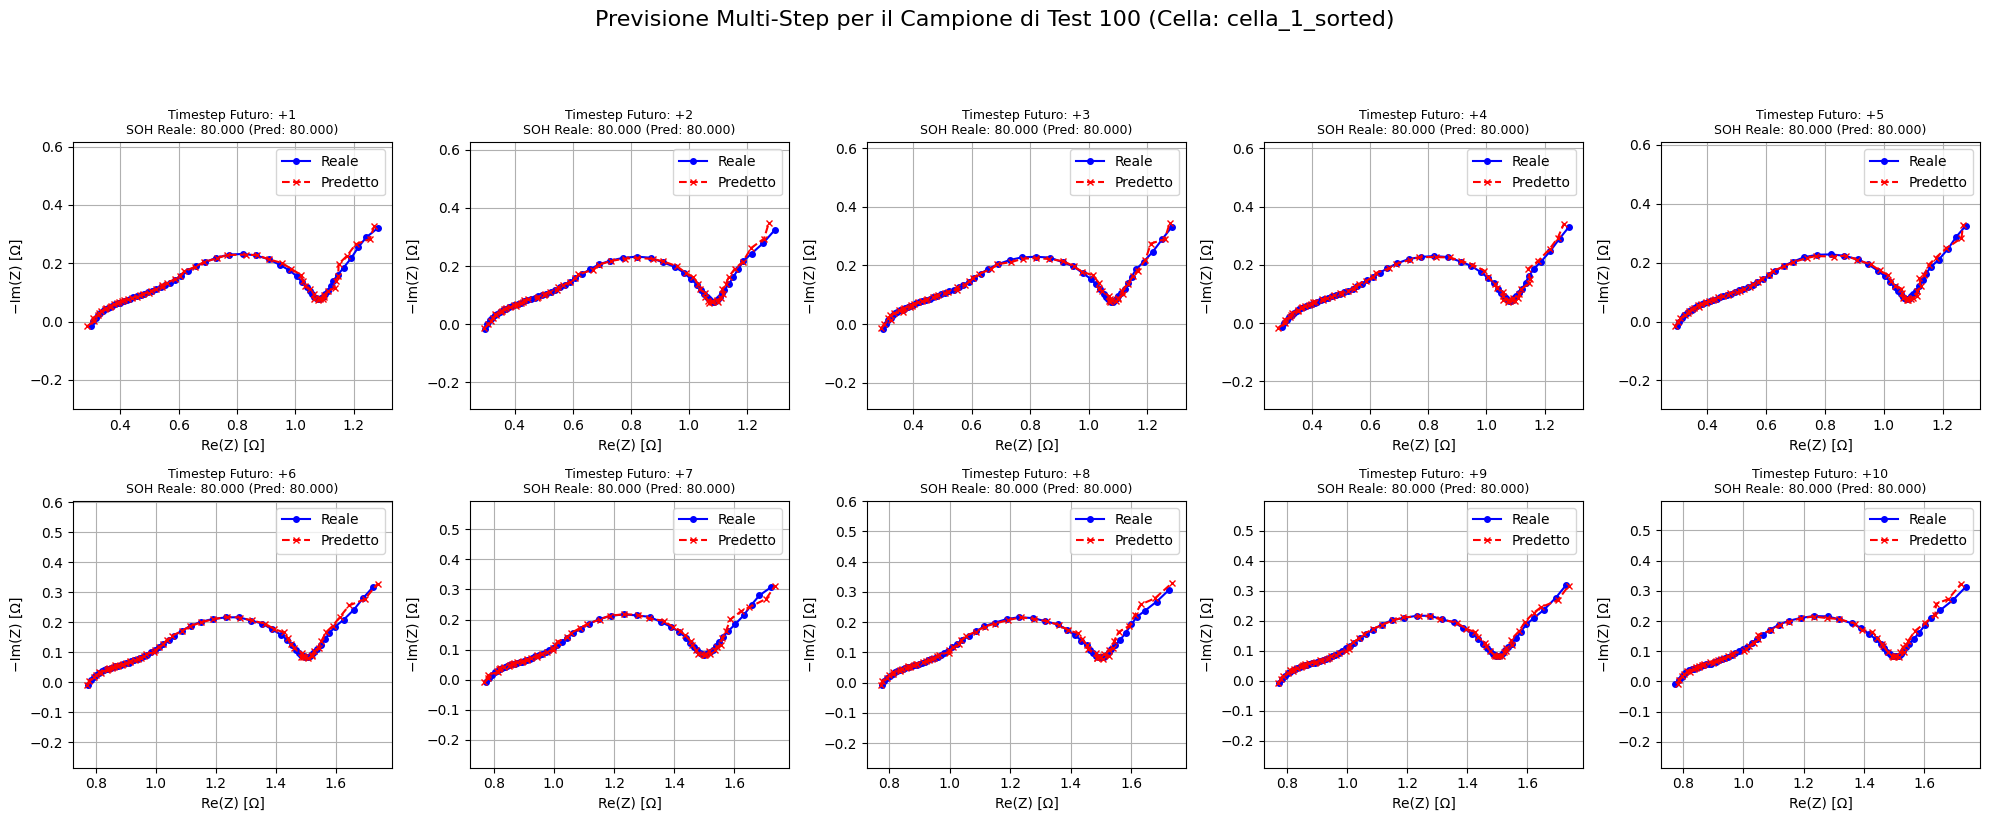

In [80]:
scalers_per_cell = load("scalers_per_cell.joblib")

print_eis_predictions(
    model=model,
    X_test_enc=X_test_enc,
    X_test_dec=X_test_dec,
    y_true_norm=y_test,
    scalers=scalers_per_cell,
    cell_ids_test=cell_ids_test, 
    index=100
)

In [23]:
model = EncoderDecoderTransformer(
    seq_len_in=SEQ_LEN_IN,
    seq_len_out=SEQ_LEN_OUT,
    num_features_in=NUM_FEATURES_IN,
    num_features_out=NUM_FEATURES_OUT,
    d_model=64,
    num_heads=6,
    ff_dim=64,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.2
)

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4), loss="mean_squared_error")


# L'input è una lista di due tensori: [encoder_input, decoder_input]
history = model.fit(
    [X_train_enc, X_train_dec], y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_enc, X_val_dec], y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            start_from_epoch=5,
            min_delta=0.0005
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=PATIENCE//4,
            min_lr=1e-7,
            verbose=1,
            min_delta=0.01
        )
    ]
)

Epoch 1/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - loss: 1.2594 - val_loss: 0.4195 - learning_rate: 1.0000e-04
Epoch 2/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4969 - val_loss: 0.1726 - learning_rate: 1.0000e-04
Epoch 3/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2825 - val_loss: 0.0974 - learning_rate: 1.0000e-04
Epoch 4/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1892 - val_loss: 0.0641 - learning_rate: 1.0000e-04
Epoch 5/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1355 - val_loss: 0.0447 - learning_rate: 1.0000e-04
Epoch 6/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1016 - val_loss: 0.0336 - learning_rate: 1.0000e-04
Epoch 7/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0794 - val_loss: 0.0265 - learning_rate: 1.0000e-04
Epoch 8/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0646 - val_loss: 0.0225 - learning_rate: 1.0000e-04
Epoch 9/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0540 -

In [17]:
model.save("model_mse_multi_cell.keras")

In [18]:
scalers_per_cell = load("scalers_per_cell.joblib")

unique_cells_in_test = np.unique(cell_ids_test)
all_metrics_per_cell = {}

for cell_id in unique_cells_in_test:
    metrics = evaluate_model_per_cell(
        model,
        X_test_enc,
        X_test_dec,
        y_test,
        scalers=scalers_per_cell,
        cell_ids_test=cell_ids_test,
        cell_id_to_evaluate=cell_id
    )
    if metrics:
        all_metrics_per_cell[cell_id] = metrics

--- Inizio Valutazione Specifica per 'cell_1' ---
Esecuzione previsioni su 512 campioni per 'cell_1'...



--- RISULTATI PER 'cell_1' ---
  temperature    : R2=0.9885, MSE=0.8701, MAE=0.6998
  soh            : R2=0.9813, MSE=0.4658, MAE=0.4326
  impedance_real : R2=0.9993, MSE=0.0001, MAE=0.0067
  impedance_imag : R2=0.9986, MSE=0.0000, MAE=0.0026
--- Inizio Valutazione Specifica per 'cell_2' ---
Esecuzione previsioni su 768 campioni per 'cell_2'...

--- RISULTATI PER 'cell_2' ---
  temperature    : R2=0.9850, MSE=0.3734, MAE=0.3667
  soh            : R2=0.9898, MSE=0.4292, MAE=0.3971
  impedance_real : R2=0.9994, MSE=0.0000, MAE=0.0044
  impedance_imag : R2=0.9982, MSE=0.0000, MAE=0.0019
--- Inizio Valutazione Specifica per 'cell_3' ---
Esecuzione previsioni su 256 campioni per 'cell_3'...

--- RISULTATI PER 'cell_3' ---
  temperature    : R2=1.0000, MSE=0.0000, MAE=0.0000
  soh            : R2=0.9963, MSE=0.6016, MAE=0.4984
  impedance_real : R2=0.9831, MSE=0.0039, MAE=0.0356
  impedance_imag : R2=0.9694, MSE=0.0015, MAE=0.0184


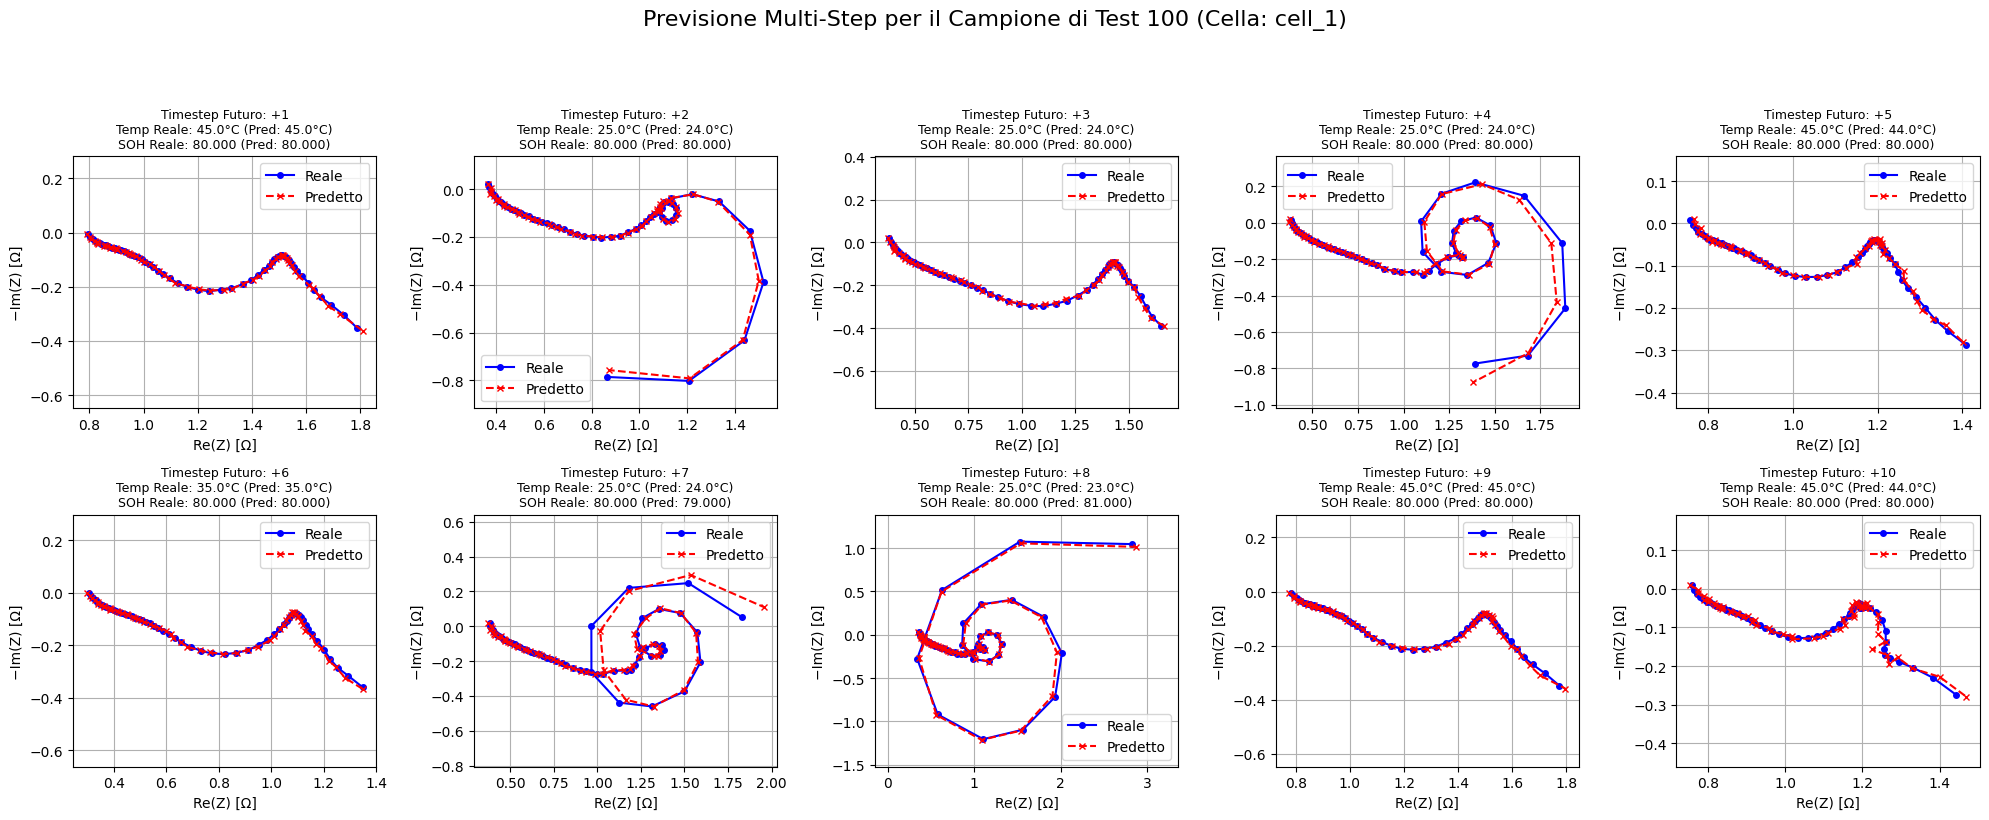

In [24]:
scalers_per_cell = load("scalers_per_cell.joblib")

print_eis_predictions(
    model=model,
    X_test_enc=X_test_enc,
    X_test_dec=X_test_dec,
    y_true_norm=y_test,
    scalers=scalers_per_cell,
    cell_ids_test=cell_ids_test, 
    index=100
)

In [17]:
model = tf.keras.models.load_model(
    "model_mse_multi_cell.keras"
)


2025-09-23 08:32:30.828957: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [18]:
import numpy as np
import tensorflow as tf

def autoregressive_forecast(model, X_enc, seq_len_out, start_token=None):
    """
    Genera la sequenza di output in modo autoregressivo (senza teacher forcing).
    """
    n_features = X_enc.shape[-1]
    if start_token is None:
        start_token = np.zeros((n_features,), dtype=np.float32)

    # inizializza decoder con solo il token iniziale
    y_dec = np.repeat(start_token[None, None, :], X_enc.shape[0], axis=0)  # (B,1,F)

    preds = []
    for _ in range(seq_len_out):
        # predizione step corrente
        y_pred = model.predict([X_enc, y_dec], verbose=0)[:, -1:, :]  # ultimo timestep
        preds.append(y_pred)
        # aggiungi la predizione corrente al decoder
        y_dec = np.concatenate([y_dec, y_pred], axis=1)

    return np.concatenate(preds, axis=1)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def autoregressive_forecast(model, X_enc, y_true, start_token=None, verbose=True):
    """
    Genera previsioni autoregressive step-by-step e calcola MSE e MAE globali.

    Args:
        model: modello seq2seq (es. EncoderDecoderTransformer)
        X_enc: input per l’encoder (shape: [batch, seq_len_in, features])
        y_true: target reale (shape: [batch, seq_len_out, features])
        start_token: vettore iniziale per il decoder ([features_out])
        verbose: se True, stampa metriche

    Returns:
        y_pred: predizioni generate (shape: [batch, seq_len_out, features])
        mse: Mean Squared Error (float)
        mae: Mean Absolute Error (float)
    """
    batch_size = X_enc.shape[0]
    seq_len_out = y_true.shape[1]
    n_features = y_true.shape[2]

    # token iniziale
    if start_token is None:
        start_token = np.zeros((n_features,), dtype=np.float32)

    # inizializza decoder con solo il token iniziale
    y_dec = np.repeat(start_token[None, None, :], batch_size, axis=0)  # (B,1,F)

    preds = []
    for _ in range(seq_len_out):
        # predizione step corrente
        y_pred = model.predict([X_enc, y_dec], verbose=0)[:, -1:, :]  # ultimo timestep
        preds.append(y_pred)
        # aggiungi la nuova predizione come input per il passo successivo
        y_dec = np.concatenate([y_dec, y_pred], axis=1)

    # unisci tutte le predizioni
    y_pred = np.concatenate(preds, axis=1)  # (B, seq_len_out, F)

    # metriche globali
    mse = mean_squared_error(y_true.reshape(-1), y_pred.reshape(-1))
    mae = mean_absolute_error(y_true.reshape(-1), y_pred.reshape(-1))

    if verbose:
        print(f"🔁 Autoregressive forecast done for {seq_len_out} steps")
        print(f"📊 MSE: {mse:.6f} | MAE: {mae:.6f}")

    return y_pred, mse, mae


In [ ]:
y_pred_val, mse_val, mae_val = autoregressive_forecast(model, X_val_enc, y_val)
y_pred_test, mse_test, mae_test = autoregressive_forecast(model, X_test_enc, y_test)

print(f"Validation -> MSE: {mse_val:.6f} | MAE: {mae_val:.6f}")
print(f"Test       -> MSE: {mse_test:.6f} | MAE: {mae_test:.6f}")



🔁 Generating validation predictions autoregressively...


2025-11-03 10:14:27.659142: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32,2,64] vs. [10,64]
	 [[{{node encoder_decoder_transformer_4_1/add_7}}]]


InvalidArgumentError: Graph execution error:

Detected at node encoder_decoder_transformer_4_1/add_7 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 614, in shell_main

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_shell

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 366, in execute_request

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 827, in execute_request

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 458, in do_execute

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 663, in run_cell

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/var/folders/8d/jbqc1pzn69qbpq_7zqmvvc0m0000gn/T/ipykernel_75372/4092815153.py", line 2, in <module>

  File "/var/folders/8d/jbqc1pzn69qbpq_7zqmvvc0m0000gn/T/ipykernel_75372/2331165056.py", line 8, in evaluate_autoregressive

  File "/var/folders/8d/jbqc1pzn69qbpq_7zqmvvc0m0000gn/T/ipykernel_75372/3858115988.py", line 18, in autoregressive_forecast

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 588, in predict

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 282, in one_step_on_data_distributed

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 271, in one_step_on_data

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in predict_step

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/Users/francescorusso/Desktop/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/8d/jbqc1pzn69qbpq_7zqmvvc0m0000gn/T/ipykernel_75372/1335839575.py", line 75, in call

Incompatible shapes: [32,2,64] vs. [10,64]
	 [[{{node encoder_decoder_transformer_4_1/add_7}}]] [Op:__inference_one_step_on_data_distributed_8209]